In [1]:
import numpy as np
import circe as ci
import scanpy as sc
import scipy as sp
import warnings
import pandas as pd 
warnings.filterwarnings('ignore')

In [2]:
regions = ['AMY','HIP','PFC']
celltypes = ['OPC-Oligo', 'Immune','Astro-Epen','Vascular']


In [21]:
region = 'AMY'
celltype = 'Vascular'
condition = 'MC'
base_name = f"{region}_{celltype}"


In [4]:
base_name

'AMY_Vascular'

In [6]:
adata_all = sc.read_h5ad(f"output/atac0416/3REGIONS_peak.h5ads")

In [24]:
region = "HIP"
#celltype = args.celltype
celltype_column = "celltype.L2"
adatasubset = adata_all[(adata_all.obs['sample'].str.contains(region)) & (adata_all.obs['expriment'].str.contains(condition))]

In [25]:
adatasubset.obs

,sample,leiden,celltype.L2,leiden_tile,celltype.L1,region,Neurotransmitter_celltype,region_nt,celltype.L3,celltype.L4,expriment
MC39C_HIP:AAACGAAAGACTAGCG-1,MC39C_HIP,9,Immune,9,Immune,HIP,NN,NN,Immune-0,Immune-0-0,MC
MC39C_HIP:AAACGAAAGAGGTCCA-1,MC39C_HIP,11,OPC-Oligo,11,OPC-Oligo,HIP,NN,NN,OPC-Oligo-0,OPC-Oligo-0-0,MC
MC39C_HIP:AAACGAAAGATGAGGA-1,MC39C_HIP,12,Hippo_DG_GC,12,Neuron,HIP,Glutamatergic,HIP_Glut,Hippo_DG_GC-1,Hippo_DG_GC-1-0,MC
MC39C_HIP:AAACGAAAGGCTTAAA-1,MC39C_HIP,3,Hippo_Mossy_cell,3,Neuron,HIP,Glutamatergic,HIP_Glut,Hippo_Mossy_cell-0,Hippo_Mossy_cell-0-2,MC
MC39C_HIP:AAACGAAAGGGACGTT-1,MC39C_HIP,3,Hippo_DG_GC,3,Neuron,HIP,Glutamatergic,HIP_Glut,Hippo_DG_GC-0,Hippo_DG_GC-0-1,MC
...,...,...,...,...,...,...,...,...,...,...,...
MC50B_HIP:TTTGTGTGTAGACGCA-1,MC50B_HIP,3,Hippo_DG_GC,3,Neuron,HIP,Glutamatergic,HIP_Glut,Hippo_DG_GC-0,Hippo_DG_GC-0-1,MC
MC50B_HIP:TTTGTGTGTCAGAAAT-1,MC50B_HIP,4,Hippo_CA1-d_pyramidal,4,Neuron,HIP,Glutamatergic,HIP_Glut,Hippo_CA1-d_pyramidal-1,Hippo_CA1-d_pyramidal-1-1,MC
MC50B_HIP:TTTGTGTGTGTTTCTT-1,MC50B_HIP,9,Immune,9,Immune,HIP,NN,NN,Immune-0,Immune-0-0,MC
MC50B_HIP:TTTGTGTGTTCTCGAA-1,MC50B_HIP,11,OPC-Oligo,11,OPC-Oligo,HIP,NN,NN,OPC-Oligo-0,OPC-Oligo-0-0,MC


In [26]:
for celltype in adatasubset.obs[celltype_column].unique()[2:3]:
    print(celltype)
    adata_subset = adatasubset[adatasubset.obs[celltype_column] == celltype]


Hippo_DG_GC


In [27]:
adata = adata_subset

In [28]:
adata

View of AnnData object with n_obs × n_vars = 9302 × 1371000
    obs: 'sample', 'leiden', 'celltype.L2', 'leiden_tile', 'celltype.L1', 'region', 'Neurotransmitter_celltype', 'region_nt', 'celltype.L3', 'celltype.L4', 'expriment'
    uns: 'log1p'
    obsm: 'X_spectral', 'X_umap'
    layers: 'count'

In [29]:
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=200)
adata.var.index=adata.var.index.str.replace(":", "_").str.replace("-", "_")
# Column to use for stratification
if adata.shape[0] > 5000:
    # stratify_column = 'expriment'

    # # Number of cells to sample from each group
    # n_samples_per_group = 2500

    # # Perform stratified sampling
    # sampled_indices = (
    #     adata.obs
    #     .groupby(stratify_column, group_keys=False)
    #     .apply(lambda x: x.sample(min(n_samples_per_group, len(x))))
    #     .index
    # )
    # adata  = adata[sampled_indices, :]
    adata = sc.pp.subsample(adata, n_obs=5000, copy=True)


In [13]:
%%capture
adata = ci.add_region_infos(adata)

In [14]:
%%capture
ci.compute_atac_network(
    adata, #metacells,
    organism="mouse",
)

In [15]:
%%capture
final_score = ci.sliding_graphical_lasso(
    adata,
    n_samples=50,
    n_samples_maxtry=100,
    max_alpha_iteration=500,
    verbose=True
)
adata.varp['atac_network'] = final_score


In [16]:
adata.varp['atac_network']

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 41254444 stored elements and shape (1370603, 1370603)>

In [17]:
circe_network = ci.extract_atac_links(adata) #metacells)
circe_network.head(10)


,Peak1,Peak2,score
0,chr9_19265882_19266383,chr9_19677500_19678001,0.877873
1,chr16_47002643_47003144,chr16_47420061_47420562,0.866347
2,chr17_21798758_21799259,chr17_21951316_21951817,0.850599
3,chr6_7155260_7155761,chr6_7291273_7291774,0.846532
4,chr17_93811588_93812089,chr17_93884144_93884645,0.845363
5,chr2_36560452_36560953,chr2_36931190_36931691,0.842678
6,chr2_149184106_149184607,chr2_149184638_149185139,0.841999
7,chr6_41264200_41264701,chr6_41383767_41384268,0.840089
8,chr7_108825817_108826318,chr7_108830010_108830511,0.838546
9,chr16_47000195_47000696,chr16_47002643_47003144,0.828722


In [31]:
adata_shuffle =  adata.copy()

In [32]:
adata_shuffle

AnnData object with n_obs × n_vars = 5000 × 1365553
    obs: 'sample', 'leiden', 'celltype.L2', 'leiden_tile', 'celltype.L1', 'region', 'Neurotransmitter_celltype', 'region_nt', 'celltype.L3', 'celltype.L4', 'expriment', 'n_genes'
    var: 'n_cells'
    uns: 'log1p'
    obsm: 'X_spectral', 'X_umap'
    layers: 'count'

In [33]:
from sklearn.utils import shuffle
shuffled_matrix = shuffle(adata_shuffle.X.T, random_state=42).T


In [34]:
adata_shuffle.X = shuffled_matrix

In [ ]:
# sc.pp.filter_genes(adata_shuffle, min_cells=3)
# sc.pp.filter_cells(adata_shuffle, min_genes=200)
# adata_shuffle.var.index=adata_shuffle.var.index.str.replace(":", "_").str.replace("-", "_")


In [38]:
if adata_shuffle.shape[0] > 5000:
    stratify_column = 'expriment'

    # Number of cells to sample from each group
    n_samples_per_group = 2500

    # Perform stratified sampling
    sampled_indices = (
        adata_shuffle.obs
        .groupby(stratify_column, group_keys=False)
        .apply(lambda x: x.sample(min(n_samples_per_group, len(x))))
        .index
    )
    adata_shuffle  = adata_shuffle[sampled_indices, :]

In [35]:
adata_shuffle = ci.add_region_infos(adata_shuffle)
ci.compute_atac_network(
    adata_shuffle, #metacells,
    organism="mouse",
)
final_score = ci.sliding_graphical_lasso(
    adata_shuffle,
    n_samples=50,
    n_samples_maxtry=100,
    max_alpha_iteration=500,
    verbose=True
)
adata_shuffle.varp['atac_network'] = final_score
circe_network = ci.extract_atac_links(adata_shuffle) #metacells)


http://10.21.20.24:38231/status


In [41]:
circe_network_shuffle = ci.extract_atac_links(adata_shuffle) #metacells)
circe_network=ci.extract_atac_links(adata) #metacells)

In [46]:
from scipy import stats
mu,sigma = stats.norm.fit(circe_network_shuffle['score'])

In [59]:
circe_network.shape

(20581282, 3)

In [57]:
from statsmodels.stats.multitest import multipletests

p_values = 1 - stats.norm.cdf(circe_network['score'], loc=mu, scale=sigma)

# 3. FDR correction
reject, pvals_corrected, _, _ = multipletests(
    p_values, alpha=0.001, method='fdr_bh')


In [62]:
circe_network_fdr_corrected = circe_network.loc[reject]

In [63]:
circe_network_fdr_corrected

,Peak1,Peak2,score
0,chrX_108215558_108216059,chrX_108414436_108414937,0.871550
1,chr8_19221919_19222420,chr8_19225132_19225633,0.867646
2,chr7_18186822_18187323,chr7_18187442_18187943,0.842246
3,chr6_68680927_68681428,chr6_68755004_68755505,0.840266
4,chrX_63390459_63390960,chrX_63391788_63392289,0.832288
...,...,...,...
742201,chr3_66680092_66680593,chr3_66776762_66777263,0.032875
742202,chr13_3774180_3774681,chr13_3917964_3918465,0.032875
742203,chr2_81437509_81438010,chr2_81562508_81563009,0.032875
742204,chr7_13007641_13008142,chr7_13035169_13035670,0.032875


In [64]:
ccans = ci.find_ccans(circe_network_fdr_corrected, seed=0)


Coaccessibility cutoff used: 0.14
Number of CCANs generated: 10040


In [66]:
adata = ci.add_ccans(adata)

Coaccessibility cutoff used: 0.14


In [ ]:
circe_network.to_csv(f"/data2st1/junyi/output/cicre/{base_name}_circe_network.csv")

In [ ]:
ccans.to_csv(f"/data2st1/junyi/output/cicre/{base_name}_ccans.csv")

In [ ]:
adata = ci.add_ccans(adata)


In [ ]:
adata.var.head()


In [135]:
from matplotlib import pyplot as plt


In [2]:
adata = sc.read_h5ad(f"/data1st2/junyi/output/atac0416/cicre/region_nt/PFC_PFC_Glut_MW_circe.h5ad")

In [69]:
adata.var

,n_cells,chromosome,start,end,CCAN
chr1_3003627_3004128,67,chr1,3003627,3004128,None
chr1_3008717_3009218,56,chr1,3008717,3009218,None
chr1_3012481_3012982,272,chr1,3012481,3012982,None
chr1_3013424_3013925,39,chr1,3013424,3013925,None
chr1_3014320_3014821,68,chr1,3014320,3014821,0
...,...,...,...,...,...
chrY_90811475_90811976,1021,chrY,90811475,90811976,21620
chrY_90812130_90812631,1080,chrY,90812130,90812631,21701
chrY_90812678_90813179,780,chrY,90812678,90813179,21701
chrY_90813375_90813876,526,chrY,90813375,90813876,21701


In [74]:
# grouby by CCAN and concat the index strings
ccan_modules = adata.var.groupby('CCAN').agg(lambda x: '/'.join(x.index)).reset_index()

In [78]:
ccan_modules

,CCAN,n_cells,chromosome,start,end
0,0,chr1_3014320_3014821/chr1_3094188_3094689/chr1...,chr1_3014320_3014821/chr1_3094188_3094689/chr1...,chr1_3014320_3014821/chr1_3094188_3094689/chr1...,chr1_3014320_3014821/chr1_3094188_3094689/chr1...
1,2,chr1_4051651_4052152/chr1_4063230_4063731/chr1...,chr1_4051651_4052152/chr1_4063230_4063731/chr1...,chr1_4051651_4052152/chr1_4063230_4063731/chr1...,chr1_4051651_4052152/chr1_4063230_4063731/chr1...
2,3,chr1_5678546_5679047/chr1_5689284_5689785/chr1...,chr1_5678546_5679047/chr1_5689284_5689785/chr1...,chr1_5678546_5679047/chr1_5689284_5689785/chr1...,chr1_5678546_5679047/chr1_5689284_5689785/chr1...
3,5,chr1_5702506_5703007/chr1_5703101_5703602/chr1...,chr1_5702506_5703007/chr1_5703101_5703602/chr1...,chr1_5702506_5703007/chr1_5703101_5703602/chr1...,chr1_5702506_5703007/chr1_5703101_5703602/chr1...
4,7,chr1_5704620_5705121/chr1_5714326_5714827/chr1...,chr1_5704620_5705121/chr1_5714326_5714827/chr1...,chr1_5704620_5705121/chr1_5714326_5714827/chr1...,chr1_5704620_5705121/chr1_5714326_5714827/chr1...
...,...,...,...,...,...
8514,21491,chrY_90740205_90740706/chrY_90740917_90741418/...,chrY_90740205_90740706/chrY_90740917_90741418/...,chrY_90740205_90740706/chrY_90740917_90741418/...,chrY_90740205_90740706/chrY_90740917_90741418/...
8515,21509,chrY_90743071_90743572/chrY_90743730_90744231/...,chrY_90743071_90743572/chrY_90743730_90744231/...,chrY_90743071_90743572/chrY_90743730_90744231/...,chrY_90743071_90743572/chrY_90743730_90744231/...
8516,21620,chrY_90809240_90809741/chrY_90809950_90810451/...,chrY_90809240_90809741/chrY_90809950_90810451/...,chrY_90809240_90809741/chrY_90809950_90810451/...,chrY_90809240_90809741/chrY_90809950_90810451/...
8517,21701,chrY_90812130_90812631/chrY_90812678_90813179/...,chrY_90812130_90812631/chrY_90812678_90813179/...,chrY_90812130_90812631/chrY_90812678_90813179/...,chrY_90812130_90812631/chrY_90812678_90813179/...


In [75]:
ccan_counts = adata.var.groupby('CCAN').size().reset_index(name='count')

In [76]:
ccan_counts = adata.var.groupby('CCAN').size().reset_index(name='count')


In [79]:
ccan_counts['regions'] = ccan_modules["n_cells"]

In [81]:
ccan_counts = ccan_counts[ccan_counts['CCAN'] != 'None']


In [82]:
ccan_counts

,CCAN,count,regions
0,0,49,chr1_3014320_3014821/chr1_3094188_3094689/chr1...
1,2,105,chr1_4051651_4052152/chr1_4063230_4063731/chr1...
2,3,3,chr1_5678546_5679047/chr1_5689284_5689785/chr1...
3,5,3,chr1_5702506_5703007/chr1_5703101_5703602/chr1...
4,7,10,chr1_5704620_5705121/chr1_5714326_5714827/chr1...
...,...,...,...
8513,21450,3,chrY_90737885_90738386/chrY_90738878_90739379/...
8514,21491,3,chrY_90740205_90740706/chrY_90740917_90741418/...
8515,21509,3,chrY_90743071_90743572/chrY_90743730_90744231/...
8516,21620,4,chrY_90809240_90809741/chrY_90809950_90810451/...


In [26]:
df_dar = pd.read_csv(f"/data2st1/junyi/output/atac0526/dar/region_nt/PFC_PFC_Glut_MW_mementob.csv",index_col=0)

In [29]:
df_dar["gene_cicre"]= df_dar["gene"].str.replace(r"[:-]", "_")

In [58]:
adata.var[adata.var['CCAN']=="21023"]

,n_cells,chromosome,start,end,CCAN
chrX_170013975_170014476,148,chrX,170013975,170014476,21023
chrX_170672528_170673029,931,chrX,170672528,170673029,21023
chrX_170673205_170673706,3041,chrX,170673205,170673706,21023
chrX_170674122_170674623,3176,chrX,170674122,170674623,21023


In [34]:
df_m = df_dar.merge(adata.var, left_on='gene_cicre', right_index=True, how='left')

In [91]:
df_m

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,gene_cicre,n_cells,chromosome,start,end,CCAN
7849,chr12:11673243-11673744,stim,-0.665026,0.026588,2.042993e-137,-0.049188,0.096593,0.630810,chr12_11673243_11673744,4879,chr12,11673243,11673744,None
35632,chr8:14467983-14468484,stim,-0.489534,0.019870,1.141291e-133,-0.161713,0.065157,0.017307,chr8_14467983_14468484,7641,chr8,14467983,14468484,None
38864,chr9:64501099-64501600,stim,-0.545117,0.022630,4.917567e-127,0.024677,0.063384,0.625677,chr9_64501099_64501600,6314,chr9,64501099,64501600,None
37653,chr9:10229598-10230099,stim,-0.692191,0.029066,5.557045e-125,-0.072977,0.080581,0.358051,chr9_10229598_10230099,4429,chr9,10229598,10230099,None
131,chr1:22939759-22940260,stim,-0.652602,0.027570,3.805756e-124,-0.158220,0.077515,0.042091,chr1_22939759_22940260,4699,chr1,22939759,22940260,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13435,chr15:73757095-73757596,stim,-0.001216,0.035494,9.971105e-01,0.287551,0.135726,0.038836,chr15_73757095_73757596,2063,chr15,73757095,73757596,None
27005,chr4:134287616-134288117,stim,-0.001437,0.028546,9.976809e-01,0.143573,0.107913,0.156272,chr4_134287616_134288117,3143,chr4,134287616,134288117,None
22850,chr2:163939507-163940008,stim,-0.000087,0.034987,9.984615e-01,-0.066696,0.093849,0.456737,chr2_163939507_163940008,2083,chr2,163939507,163940008,None
13537,chr15:75566440-75566941,stim,-0.000355,0.032234,9.989622e-01,0.051638,0.112690,0.595188,chr15_75566440_75566941,2547,chr15,75566440,75566941,None


In [ ]:
# df_mn = df_m[df_m['CCAN']!="None"].sort_values(by='CCAN',ascending=False)

In [92]:
df_mn = df_m.merge(ccan_counts, on='CCAN', how='left')

In [93]:
df_mn.to_csv(f"/data2st1/junyi/output/atac0526/dar/region_nt/PFC_PFC_Glut_MW_mementob_cicre.csv")

In [95]:
df_mn.sort_values(by='count', ascending=False)

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,gene_cicre,n_cells,chromosome,start,end,CCAN,count,regions
20507,chr13:3917964-3918465,stim,-0.200443,0.030549,4.325135e-11,-0.037717,0.138054,0.771958,chr13_3917964_3918465,2963,chr13,3917964,3918465,1808,461.0,chr13_3856112_3856613/chr13_3856645_3857146/ch...
19444,chr13:12650156-12650657,stim,-0.177221,0.025736,5.456916e-12,0.209767,0.114121,0.058409,chr13_12650156_12650657,3998,chr13,12650156,12650657,1808,461.0,chr13_3856112_3856613/chr13_3856645_3857146/ch...
1200,chr5:83054748-83055249,stim,-0.469896,0.030719,4.754494e-53,-0.153832,0.115852,0.153895,chr5_83054748_83055249,3386,chr5,83054748,83055249,8285,443.0,chr5_78926917_78927418/chr5_78931357_78931858/...
8057,chr18:16037723-16038224,stim,-0.324728,0.031069,1.922100e-25,-0.103990,0.106038,0.356515,chr18_16037723_16038224,3228,chr18,16037723,16038224,3919,327.0,chr18_9768054_9768555/chr18_9784883_9785384/ch...
16414,chr15:33480519-33481020,stim,-0.215135,0.027816,1.083248e-14,0.104745,0.098594,0.243256,chr15_33480519_33481020,3680,chr15,33480519,33481020,2836,301.0,chr15_29355356_29355857/chr15_29356292_2935679...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38725,chr15:73757095-73757596,stim,-0.001216,0.035494,9.971105e-01,0.287551,0.135726,0.038836,chr15_73757095_73757596,2063,chr15,73757095,73757596,None,NaN,NaN
38726,chr4:134287616-134288117,stim,-0.001437,0.028546,9.976809e-01,0.143573,0.107913,0.156272,chr4_134287616_134288117,3143,chr4,134287616,134288117,None,NaN,NaN
38727,chr2:163939507-163940008,stim,-0.000087,0.034987,9.984615e-01,-0.066696,0.093849,0.456737,chr2_163939507_163940008,2083,chr2,163939507,163940008,None,NaN,NaN
38728,chr15:75566440-75566941,stim,-0.000355,0.032234,9.989622e-01,0.051638,0.112690,0.595188,chr15_75566440_75566941,2547,chr15,75566440,75566941,None,NaN,NaN


This CCAN module is on the chromosome: chr9


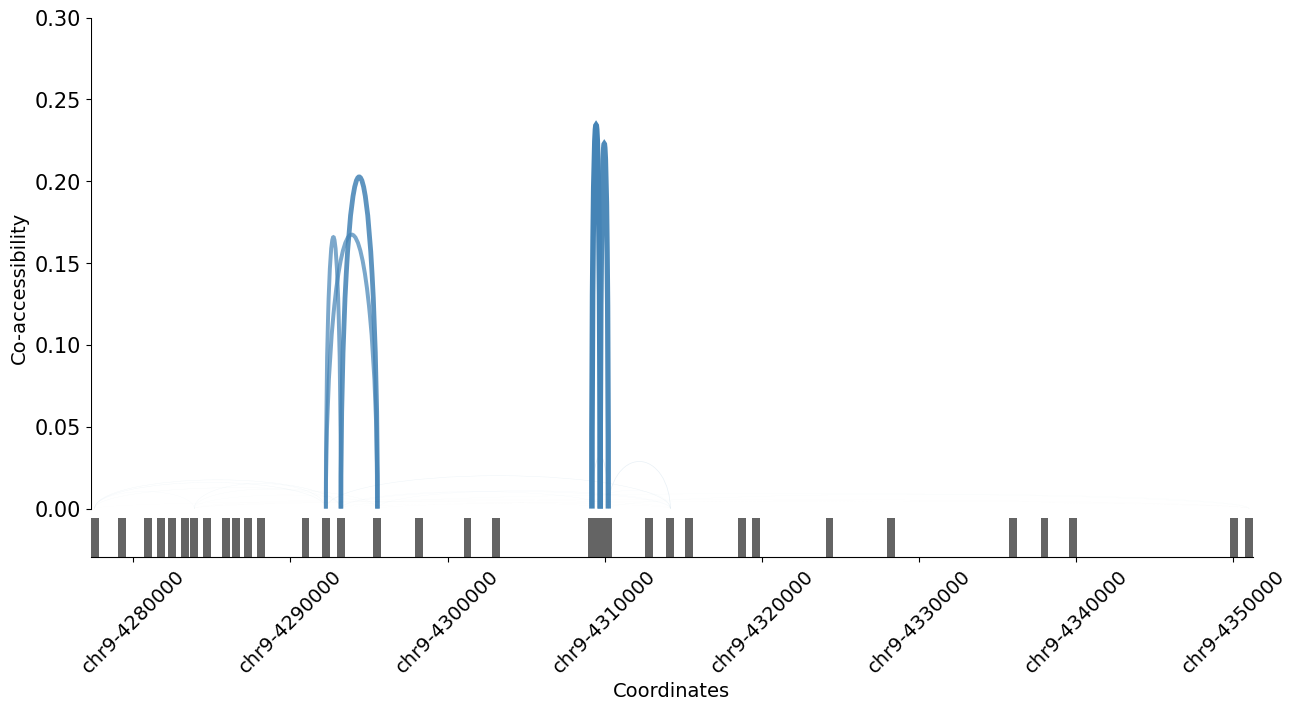

In [102]:
from matplotlib import pyplot as plt
ci.draw.plot_ccan(
    adata,
    ccan_module='13034',
    sep=('_', '_'),
    abs_threshold=0,
    figsize=(15,7),
    only_positive=True)
fig = plt.gcf()

# Rotate the y-axis labels
for ax in fig.axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotate y-axis labels
tick_locations, tick_labels = plt.xticks()


This CCAN module is on the chromosome: chr2
***** WARNING: File /data2st1/junyi/generegion_vM33/genebody.sorted.bed has inconsistent naming convention for record:
GL456210.1	9123	58882	.	-	ENSMUSG00000079800	ENSMUSG00000079800.3	genebody

***** WARNING: File /data2st1/junyi/generegion_vM33/genebody.sorted.bed has inconsistent naming convention for record:
GL456210.1	9123	58882	.	-	ENSMUSG00000079800	ENSMUSG00000079800.3	genebody

This CCAN module is on the chromosome: chr2
***** WARNING: File /data2st1/junyi/generegion_vM33/genebody.sorted.bed has inconsistent naming convention for record:
GL456210.1	9123	58882	.	-	ENSMUSG00000079800	ENSMUSG00000079800.3	genebody

***** WARNING: File /data2st1/junyi/generegion_vM33/genebody.sorted.bed has inconsistent naming convention for record:
GL456210.1	9123	58882	.	-	ENSMUSG00000079800	ENSMUSG00000079800.3	genebody

This CCAN module is on the chromosome: chr2
***** WARNING: File /data2st1/junyi/generegion_vM33/genebody.sorted.bed has inconsistent

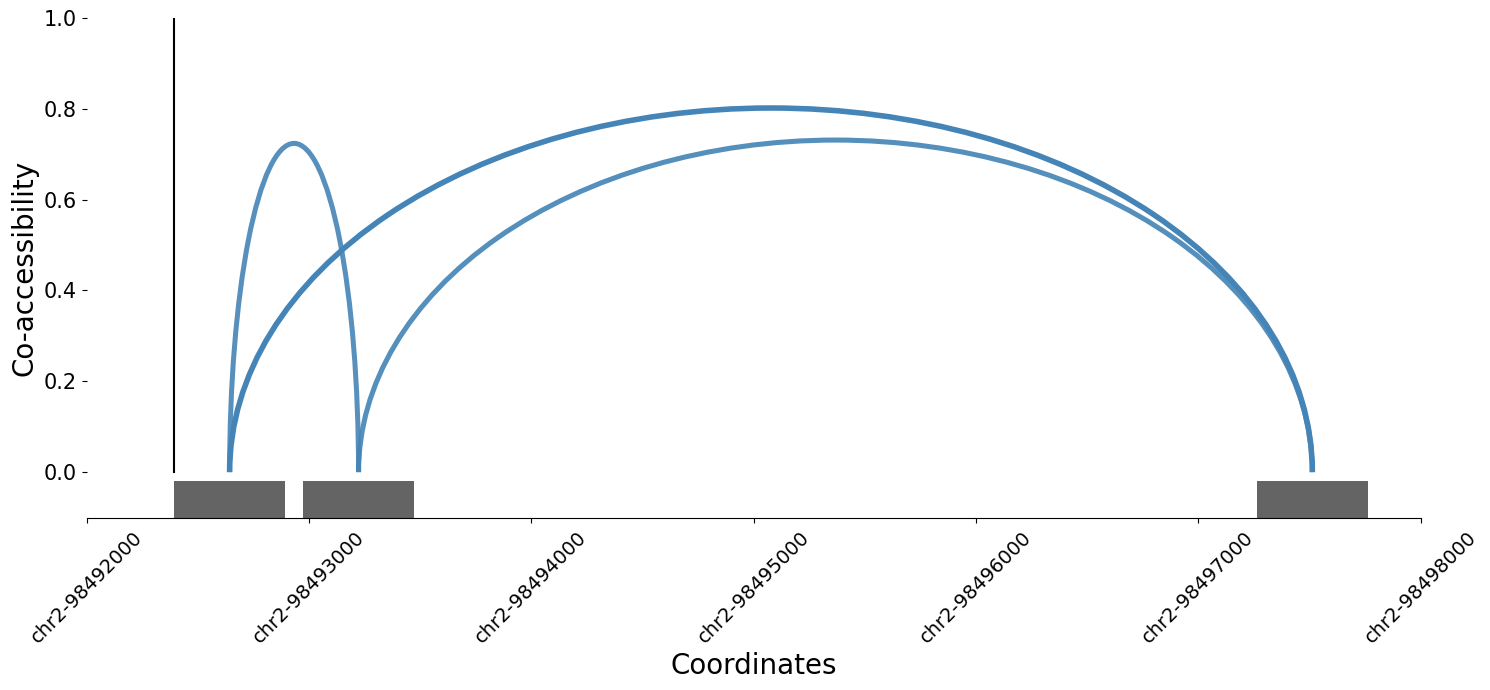

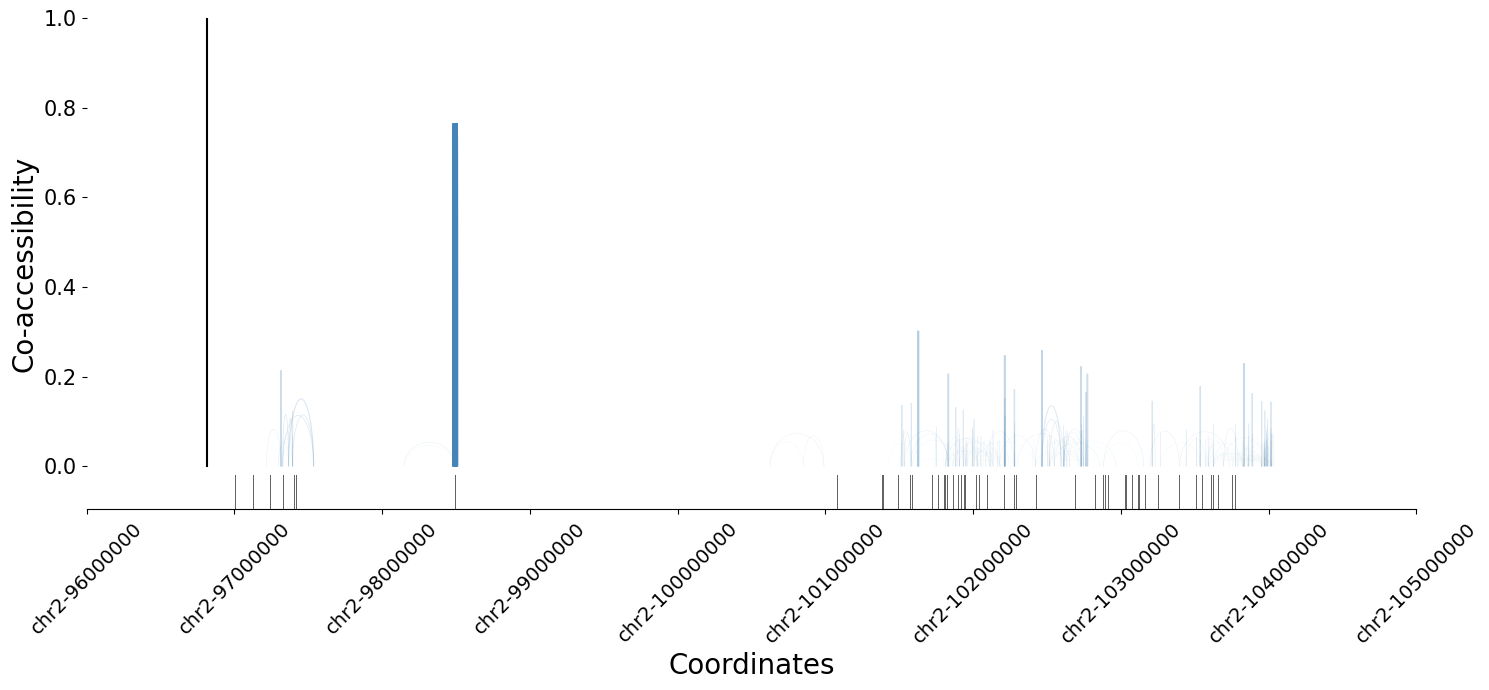

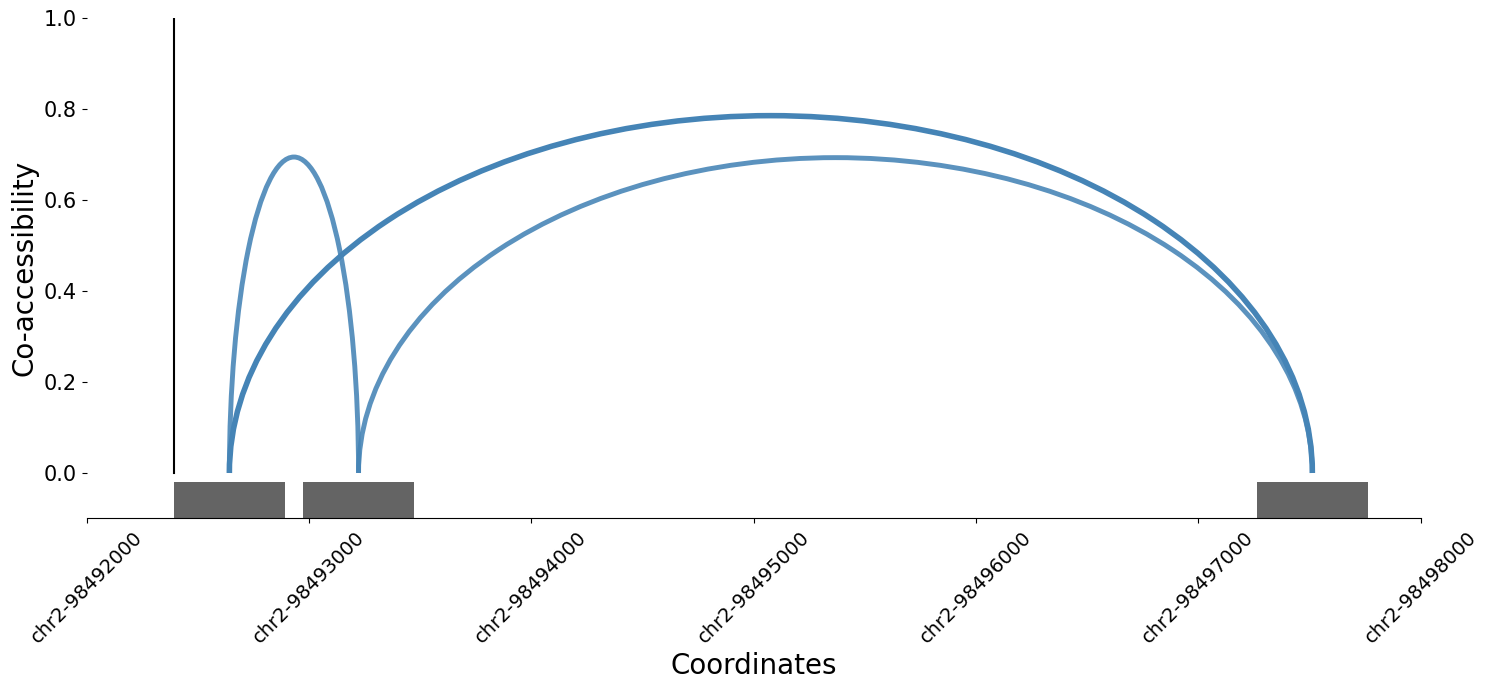

In [177]:
celltypes = ['Neuron']

for region in regions:
    for celltype in celltypes:
        base_name = f"{region}_{celltype}"
# region = 'HIP'
# celltype = 'Neuron'
# base_name = f"{region}_{celltype}"
        adata = sc.read_h5ad(f"/data2st1/junyi/output/cicre/{base_name}_circe.h5ad")
        df_ccans = pd.read_csv(f"/data2st1/junyi/output/cicre/{base_name}_circe_network.csv", index_col=0,nrows=100)
        adata.var['CCAN_old'] = adata.var['CCAN']
        adata.var['CCAN'] = adata.var['CCAN_old'].astype(str)
        adata.var['CCAN'] = adata.var['CCAN'] + "_"  +adata.var['chromosome'].astype(str) 
        df_head = adata.var.loc[(df_ccans.head(10).Peak1)]
        ci.draw.plot_ccan(
            adata,
            ccan_module=df_head[df_head.CCAN_old!='None'].head(1)['CCAN'].values[0],
            sep=('_', '_'),
            abs_threshold=0,
            figsize=(15,7),
            only_positive=True)
        fig = plt.gcf()

        # Rotate the y-axis labels
        for ax in fig.axes:
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotate y-axis labels
        tick_locations, tick_labels = plt.xticks()

        chr = df_head[df_head.CCAN_old!='None'].head(1)['chromosome'].values[0]
        for i, tick in enumerate(tick_labels):
            if tick.get_text().startswith("chr"):
                new_text = tick.get_text().replace("chr1",chr)  # Replace the text
                tick.set_text(new_text) 

        plt.xticks(tick_locations, tick_labels)
        plt.tight_layout()
        plt.savefig(f"/data2st1/junyi/output/cicre/{base_name}_ccan.png")

        df_ccans.Peak1.str.split("_", expand=True).to_csv(f"/data2st1/junyi/output/cicre/{base_name}_ccans_top.bed", sep="\t", header=False, index=False) 
        !bedtools sort -i /data2st1/junyi/generegion_vM33/genebody.bed> /data2st1/junyi/generegion_vM33/genebody.sorted.bed
        !bedtools sort -i /data2st1/junyi/output/cicre/{base_name}_ccans_top.bed> /data2st1/junyi/output/cicre/{base_name}_ccans_top.sorted.bed
        !bedtools closest -a /data2st1/junyi/output/cicre/{base_name}_ccans_top.sorted.bed -b /data2st1/junyi/generegion_vM33/genebody.sorted.bed -D ref > /data2st1/junyi/output/cicre/{base_name}_ccans_top.gene.bed